<a href="https://colab.research.google.com/github/alkashef/flower-classification/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Hyper-parameters and preamble

### Global variables and hyper-params

In [0]:
github_account = 'https://github.com/alkashef/'
repo_name = 'flower-classification'
project_name = 'identify_flower_species'
colab = True
verbose = True
reload_checkpoint = False
print_mini_batch = False
retrain_features = False

# hyper-parameters
hp = {'input_layer'     : 2048,
      'hidden_layer_1'  : 1024,
      'hidden_layer_2'  : 512,
      'output_layer'    : 102,
      'learning_rate'   : 0.003,
      'no_epochs'       : 200,
      'batch_size'      : 128,
      'dropout_rate'    : 0.2,
      'num_workers'     : 0,
      'sample'          : 1,
      'base_model'      : 'resnet101'} # resnet34 # resnet50

### Switch off warnings

In [0]:
import warnings
warnings.filterwarnings('ignore')

### Install libraries on Colab 

In [3]:
if colab:
    !pip install torch torchvision
    import torch
        
    !pip uninstall -y Pillow
    !pip install Pillow==4.0.0
    !pip install PIL
    !pip install image

Uninstalling Pillow-4.3.0:
  Successfully uninstalled Pillow-4.3.0
     |████████████████████████████████| 5.6MB 3.4MB/s 
ERROR: torchvision 0.3.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


  ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


### Import libraries

In [0]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from google.colab import files

import numpy as np
from PIL import Image
import datetime
import time
import json
import os
import sys

### Test for CUDA

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if verbose:
    if not train_on_gpu:
        print('CUDA is not available. Training on CPU.')
    else:
        print('CUDA is available! Training on GPU.')

CUDA is available! Training on GPU.


### File paths

Set project folder and download train/valid data

In [6]:
if colab: 
    !git clone "$github_account"'/'"$repo_name"
    project_dir = os.path.join('/content/', repo_name)
else:
    project_dir = os.getcwd()

data_dir = os.path.join(project_dir, 'data')

if colab:
    !wget -nc --verbose https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
    !unzip -D -n flower_data.zip -d $data_dir
else:

Cloning into 'flower-classification'...
remote: Enumerating objects: 7643, done.
remote: Counting objects: 100% (7643/7643), done.
remote: Compressing objects: 100% (7632/7632), done.
remote: Total 7643 (delta 29), reused 7611 (delta 9), pack-reused 0
Receiving objects: 100% (7643/7643), 303.24 MiB | 45.55 MiB/s, done.
Resolving deltas: 100% (29/29), done.
--2019-07-28 12:28:27--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.65.155
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.65.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  46.9MB/s    in 5.7s    

2019-07-28 12:28:33 (51.9 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]

Archive:  flower_data.zip
   creating: /content/flower-classification/data/flower_data/
   creating: /conten

Set file paths

In [7]:
train_dir = os.path.join(data_dir, 'flower_data', 'train')
valid_dir = os.path.join(data_dir, 'flower_data', 'valid')

test_image = os.path.join(data_dir, 'test_image', 'flora.jpg')

checkpoints_path = os.path.join(project_dir, 'checkpoints') 
checkpoint_last = os.path.join(checkpoints_path, 'checkpoint_last.pth')
checkpoint_best = os.path.join(checkpoints_path, 'checkpoint_best.pth')
    
classes_dict = os.path.join(data_dir, 'cat_to_name.json')

if verbose:
    print("project_dir:", project_dir)
    print("train_dir:", train_dir)
    print("valid_dir:", valid_dir)
    print("checkpoints_path:", checkpoints_path)
    print("test_image:", test_image)
    print("classes_dict:", classes_dict)

project_dir: /content/flower-classification
train_dir: /content/flower-classification/data/flower_data/train
valid_dir: /content/flower-classification/data/flower_data/valid
checkpoints_path: /content/flower-classification/checkpoints
test_image: /content/flower-classification/data/test_image/flora.jpg
classes_dict: /content/flower-classification/data/cat_to_name.json


### Helper functions

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

#---------------------------------------------------------------------------------------

def print_dict(dict, sample=3):
    print(len(dict), 'categories')
    print("Sample categories:")
    ii = 1
    for (key, value) in dict.items():
        if (ii <= sample):
            print('\t{:3s} : {:s}'.format(key, value))
            ii = ii + 1

#---------------------------------------------------------------------------------------

def show_images(loader, sample=4, normalize=True):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(figsize=(20,sample), ncols=sample)
    for ii in range(sample):
        ax = axes[ii]
        #helper.imshow(images[ii], ax=ax, normalize=normalize)
        imshow(images[ii], ax=ax, normalize=normalize)

#---------------------------------------------------------------------------------------

def humanize_time(secs):
    mins, secs = divmod(secs, 60)
    hours, mins = divmod(mins, 60)
    return '%02d:%02d:%02d' % (hours, mins, secs)

#---------------------------------------------------------------------------------------

def plot_losses(train_losses, test_losses):
    plt.plot(test_losses, label="Validation")
    plt.plot(train_losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    val, index = torch.topk(torch.stack(test_losses), largest=False, k=1)
    print('Smallest validation loss at epoch', index.item())

#---------------------------------------------------------------------------------------

def print_checkpoint(checkpoint):
    for key, val in checkpoint.items():
        print(key, ":", val)

#---------------------------------------------------------------------------------------

def load_checkpoint(filepath, print=False):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])  
    if print: 
        print_checkpoint(checkpoint)
    return model, checkpoint['performance']

#---------------------------------------------------------------------------------------

def print_batch(label, e, no_epochs, b, no_batches):
    print("[%s] Epoch: %02d/%02d | %s batch: %03d/%03d" % \
          (datetime.datetime.now().strftime("%x %X"), 
           e+1, 
           no_epochs, 
           label, 
           b+1, 
           no_batches))

#---------------------------------------------------------------------------------------

def save_print_epoch(e, no_epochs, epoch_time, train_loss, test_loss, test_acc, best_acc, checkpoint):
    # save last
    checkpoint.update(hp)
    torch.save(checkpoint, checkpoint_last)
    
    # save best
    if (test_acc > best_acc):
        torch.save(checkpoint, checkpoint_best)
        best_saved = " (*)"
    else:
        best_saved = ''
        
    # print
    print("[%s] Epoch: %03d/%03d | %s | Train loss: %02.3f | Val loss: %02.3f | Val acc: %02.3f%s" % \
          (datetime.datetime.now().strftime("%x %X"),
           e+1, 
           no_epochs, 
           humanize_time(epoch_time), 
           train_loss, 
           test_loss, 
           test_acc,
           best_saved))

#---------------------------------------------------------------------------------------

def print_epoch_start(e, no_epochs):
    print("[%s] Epoch: %02d/%02d ..." % (datetime.datetime.now().strftime("%x %X"),e+1, no_epochs), end='\r')

#---------------------------------------------------------------------------------------

def plot_class_probs(probs, classes, cat_to_name):
    names = []
    for c in classes:
        names.append(cat_to_name[str(c)])
    names = tuple(names)
    fig, ax = plt.subplots()
    y_pos = np.arange(len(names))
    ax.barh(y_pos, probs)
    plt.yticks(y_pos, names)
    plt.show()

#---------------------------------------------------------------------------------------

def unfreeze(model, layer):
    print("Learnable parameters:")
    for name, param in model.named_parameters():
        if layer in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
        print("%-30s  |  %-5s" % (name, param.requires_grad))

#---------------------------------------------------------------------------------------

def list_layers(model):
    print("Learnable parameters:")
    for name, param in model.named_parameters():
        print(name)

# Load the data

`torchvision` is used to load the data. You can download the data [here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. Transformations, such as random scaling, cropping, and flipping, are applied to training. This will help the network generalize leading to better performance. 

Input data is resized to 224x224 pixels.

Transformations are not applied to validation, but validation images need to be resized then cropped to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets I normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ColorJitter(hue=.02, saturation=.02),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Sample the train and test datasets individually 
train_length=int(hp['sample'] * len(train_data))
train_rest_length=len(train_data)-train_length

valid_length=int(hp['sample'] * len(valid_data))
valid_rest_length=len(valid_data)-valid_length

train_data_sample, train_data_rest = torch.utils.data.random_split(train_data, (train_length, train_rest_length))
valid_data_sample, valid_data_rest = torch.utils.data.random_split(valid_data, (valid_length, valid_rest_length))

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data_sample, 
                                           batch_size=hp['batch_size'], 
                                           num_workers=hp['num_workers'],
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data_sample, 
                                           batch_size=hp['batch_size'], 
                                           num_workers=hp['num_workers'])

### Validate loaded data

In [10]:
train_size = len(train_data_sample)
valid_size = len(valid_data_sample)
total_size = train_size + valid_size
train_ratio = train_size / total_size
valid_ratio = valid_size / total_size

num_mini_batches, last_batch = divmod(train_size, train_loader.batch_size)
if last_batch > 0:
    num_mini_batches += 1
    
if verbose:
    print("Observations [Train:Validation] = %d:%d" % (train_size, valid_size))
    print("Ratio [Train:Validation] = %02.1f:%02.1f" % (train_ratio, valid_ratio))
    print("Training: %d (epochs) X %d (batches per epoch) X %d (observation per batch)" % (hp['no_epochs'], num_mini_batches, train_loader.batch_size))
    if last_batch > 0:
        print("          %d observations in last mini-batch" % (last_batch))

Observations [Train:Validation] = 6552:818
Ratio [Train:Validation] = 0.9:0.1
Training: 200 (epochs) X 52 (batches per epoch) X 128 (observation per batch)
          24 observations in last mini-batch


### Label mapping

Load mapping from category label to category name. You can find this in the file `cat_to_name.json`.

In [11]:
with open(classes_dict, 'r') as f:
    cat_to_name = json.load(f)

if verbose:
    print_dict(cat_to_name, sample=10)

102 categories
Sample categories:
	21  : fire lily
	3   : canterbury bells
	45  : bolero deep blue
	1   : pink primrose
	34  : mexican aster
	27  : prince of wales feathers
	7   : moon orchid
	16  : globe-flower
	25  : grape hyacinth
	26  : corn poppy


### Show train & valid samples

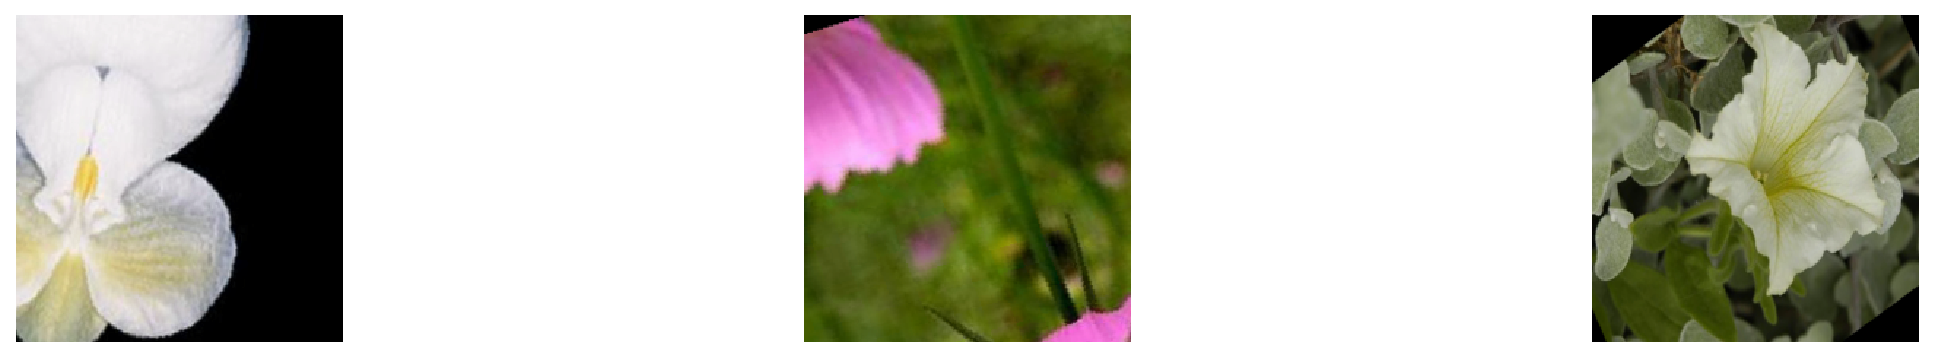

In [12]:
if verbose:
    show_images(loader=train_loader, sample=3, normalize=True)

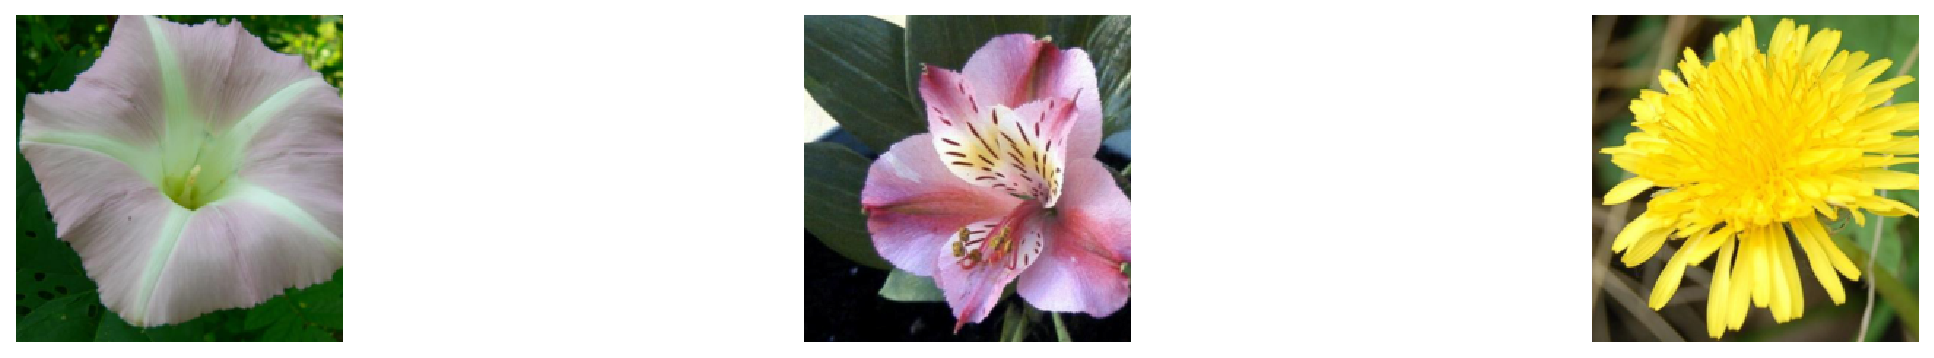

In [13]:
if verbose:
    show_images(loader=valid_loader, sample=3, normalize=True)

# Building and training the classifier


## Load pre-trained model

In [14]:
if hp['base_model'] == 'resnet34':
    model = models.resnet34(pretrained=True)
elif hp['base_model'] == 'resnet50':
    model = models.resnet50(pretrained=True)
elif hp['base_model'] == 'resnet101':
    model = models.resnet101(pretrained=True)
else:
    model = models.resnet34(pretrained=True)
if verbose:
    print(model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:04<00:00, 36854189.73it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Prep pre-trained model for fine-tuning

In [15]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(hp['input_layer'], hp['hidden_layer_1'])),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(hp['dropout_rate'])),
                          ('fc2', nn.Linear(hp['hidden_layer_1'], hp['hidden_layer_2'])),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(hp['dropout_rate'])),
                          ('fc3', nn.Linear(hp['hidden_layer_2'], hp['output_layer'])),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = classifier

if verbose:
    print(model)

criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=hp['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Load model parameters from checkpoint

In [0]:
if reload_checkpoint:
    model, best_accuracy = load_checkpoint(checkpoint_best, print=verbose)
    if verbose:
        print(model)
else:
    best_accuracy = -1.0

## Retrain features

In [0]:
if retrain_features:
    hp['no_epochs'] = 30
    #list_layers(model)
    unfreeze(model, 'layer4.2')

## Move model to GPU

In [0]:
# Move pre-trained model to CUDA
if train_on_gpu:
    model.to('cuda')

## Fine-tuning the model

In [19]:
this_epoch_loss = 1e9
train_losses = [] 
test_losses = []
t_train = time.time()
    
if verbose:
    print("Starting accuracy:", best_accuracy)
    
train_batches = np.int(np.ceil(len(train_loader.dataset)/hp['batch_size']))
test_batches = np.int(np.ceil(len(valid_loader.dataset)/hp['batch_size']))

for e in range(hp['no_epochs']):
    t_epoch = time.time()
    train_loss_epoch = 0 # Per epoch
    
    if (not print_mini_batch):
        print_epoch_start(e, hp['no_epochs'])
        
    #---------------------------------------------------------------------------------
    # Training
    for b, (images, labels) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        if print_mini_batch:
            print_batch('Training', e, hp['no_epochs'], b, train_batches)
        last_epoch_loss = this_epoch_loss
        optimizer.zero_grad()
        logits = model(images) 
        loss = criterion(logits, labels)
        train_loss_epoch += loss.item()
        loss.backward()
        optimizer.step()
    
    #---------------------------------------------------------------------------------
    # Validation
    else:      
        test_loss_epoch = 0 
        test_accuracy_epoch = 0
        
        epoch_time = time.time() - t_epoch
        
        with torch.no_grad():
            model.eval() # Switch-off dropout
        
            for b, (images, labels) in enumerate(valid_loader):
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                if print_mini_batch:
                    print_batch('Validation', e, hp['no_epochs'], b, test_batches)
                log_ps = model(images)
                test_loss_epoch += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                _, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy_epoch += torch.mean(equals.type(torch.FloatTensor))
        
        #---------------------------------------------------------------------------------
        
        model.train() # Switch-on dropout after validation
        
        #---------------------------------------------------------------------------------
        
        # Per epoch
        train_loss = train_loss_epoch/len(train_loader)
        test_loss = test_loss_epoch/len(valid_loader)
        test_accuracy = test_accuracy_epoch/len(valid_loader)
        test_accuracy = test_accuracy.item()
            
        scheduler.step(test_loss)
        
        #---------------------------------------------------------------------------------
        
        # For plotting losses
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        #---------------------------------------------------------------------------------
        
        #Saving checkpoint
        checkpoint = {'epoch': e,
                      'performance': test_accuracy,
                      'optimizer_state' : optimizer.state_dict,
                      'state_dict': model.state_dict()}
        
        save_print_epoch(e, 
                         hp['no_epochs'], 
                         epoch_time, 
                         train_loss, 
                         test_loss, 
                         test_accuracy, 
                         best_accuracy, 
                         checkpoint)
        
        #---------------------------------------------------------------------------------

        if (test_accuracy > best_accuracy):
            best_accuracy = test_accuracy
            
        #---------------------------------------------------------------------------------
              
train_time = time.time() - t_train
print("\nTotal time:", humanize_time(train_time))

Starting accuracy: -1.0
[07/28/19 12:31:08] Epoch: 001/200 | 00:01:58 | Train loss: 4.141 | Val loss: 2.389 | Val acc: 0.367 (*)
[07/28/19 12:33:18] Epoch: 002/200 | 00:01:58 | Train loss: 2.501 | Val loss: 1.622 | Val acc: 0.548 (*)
[07/28/19 12:35:29] Epoch: 003/200 | 00:01:58 | Train loss: 2.142 | Val loss: 1.278 | Val acc: 0.656 (*)
[07/28/19 12:37:39] Epoch: 004/200 | 00:01:58 | Train loss: 1.935 | Val loss: 1.146 | Val acc: 0.676 (*)
[07/28/19 12:39:49] Epoch: 005/200 | 00:01:58 | Train loss: 1.840 | Val loss: 1.002 | Val acc: 0.733 (*)
[07/28/19 12:41:59] Epoch: 006/200 | 00:01:58 | Train loss: 1.782 | Val loss: 0.993 | Val acc: 0.728


KeyboardInterrupt: ignored

## Plot train & validation losses

Smallest validation loss at epoch 5


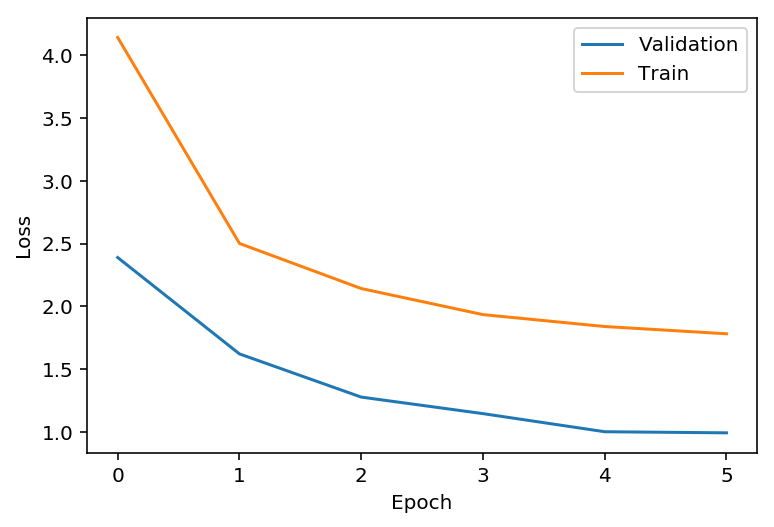

In [20]:
plot_losses(train_losses, test_losses)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [21]:
best_model, _ = load_checkpoint(checkpoint_best, print=verbose)

epoch : 4
performance : 0.7327232360839844
optimizer_state : <bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.003
    weight_decay: 0
)>
state_dict : OrderedDict([('conv1.weight', tensor([[[[ 2.0222e-02, -4.3927e-03, -1.8274e-02,  ..., -1.5180e-02,
           -1.5794e-03,  9.3115e-03],
          [-4.0752e-03,  3.2116e-03, -1.5956e-02,  ..., -8.4465e-02,
           -7.4997e-02, -4.0676e-02],
          [ 3.5039e-03,  2.6746e-02,  5.0813e-02,  ...,  3.3407e-02,
            1.3659e-02,  2.7821e-02],
          ...,
          [-3.6174e-02, -1.2986e-01, -3.0369e-01,  ..., -3.7412e-01,
           -1.3025e-01,  4.2633e-02],
          [ 1.5479e-02,  2.3444e-02,  6.5222e-03,  ..., -1.6439e-01,
           -1.8245e-01, -9.7434e-02],
          [-3.0444e-02, -1.1357e-02,  4.9984e-02,  ...,  1.6412e-01,
            1.0419e-01, -1.2681e-02]],

         [[ 8.7115e-03, -5.8911e-03, -1.2204e-02,  ..., -1.3515e-02,
          

# Inference for classification

Now I'll write a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. 

## Image Preprocessing

`PIL` is used to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). The `process_image` function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. Convert the values. 

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. Subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.


In [22]:
def process_image(image, verbose=False):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    shortest_size = 256
    std = [0.229, 0.224, 0.225]
    means = [0.485, 0.456, 0.406]
    crop_size_w = 224
    crop_size_h = 224
    
    # Load image
    im = Image.open(image)
    if verbose:
        print("Image:", image, 
              "\nFormat:", im.format, 
              "\nSize:", im.size, 
              "\nMode:", im.mode,
              "\nBands:", im.getbands())
    
    # Resize image
    w = im.size[0]
    h = im.size[1]
    if w > h:
        ratio = shortest_size / h
    else:
        ratio = shortest_size / w
    new_size = (int(ratio * w), int(ratio * h))
    im.thumbnail(new_size)
    if verbose:
        print("Resize ratio:", ratio, 
              "\nSize after resizing:", im.size)
    
    # crop out the center 224x224 portion of the image.
    new_w, new_h = new_size
    left = (new_w - crop_size_w)/2
    top = (new_h - crop_size_h)/2
    right = (new_w + crop_size_w)/2
    bottom = (new_h + crop_size_h)/2
    im_cropped = im.crop((left, top, right, bottom))
    if verbose:
        print("Cropped size:", im_cropped.size)

    # Normalize color channels between 0-1
    np_image = np.array(im_cropped)/255
    
    # reoder dimensions
    np_image = np_image.transpose()
    
    # transform (normalize) image for the network
    for i in (0, 1, 2): # R/G/B channels
        np_image[[[i]]] = (np_image[[[i]]] - means[i])/std[i]

    if verbose:
        print("Processed image type:", type(np_image))
        print("Processed image shape:", np_image.shape)
    
    return(np_image)
    
processed_image = process_image(test_image, verbose=verbose)

Image: /content/flower-classification/data/test_image/flora.jpg 
Format: JPEG 
Size: (3482, 2321) 
Mode: RGB 
Bands: ('R', 'G', 'B')
Resize ratio: 0.11029728565273589 
Size after resizing: (384, 255)
Cropped size: (224, 224)
Processed image type: <class 'numpy.ndarray'>
Processed image shape: (3, 224, 224)


To validate the `process_image` function, the function below converts a PyTorch tensor and displays it in the notebook. If `process_image` works, running the output through this function should return the original image (except for the cropped out portions).

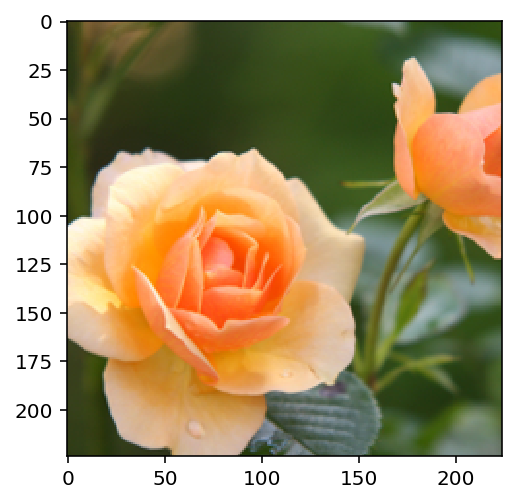

In [23]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose()
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image_tensor = torch.from_numpy(process_image(test_image))
imshow(image_tensor)

## Class Prediction

Once I get images in the correct format, thwe `predict` function makes predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes.

In [24]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        Returns propabilities list and a classes list
    '''
    
    processed_image = torch.from_numpy(process_image(image_path)).unsqueeze(0)      
    
    model, _ = load_checkpoint(model)
    if train_on_gpu:
        model = model.type(torch.DoubleTensor)
    else:
        model = model.double()
      
    model.eval()
    log_ps = model(processed_image)
    ps = torch.exp(log_ps)
    probs, classes = ps.topk(topk, dim=1)
    return probs.data.numpy()[0].tolist(), classes.numpy()[0].tolist()

probs, classes = predict(test_image, checkpoint_best, topk=5)

if verbose:
    print("Probs:", probs)
    print("Classes:", classes)

Probs: [0.380202993177605, 0.36367714892487146, 0.040134604322547306, 0.034978671535497594, 0.024204392803770926]
Classes: [74, 92, 5, 39, 3]


## Sanity Checking

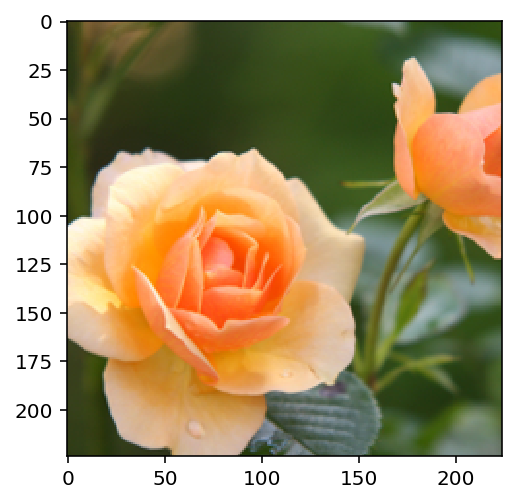

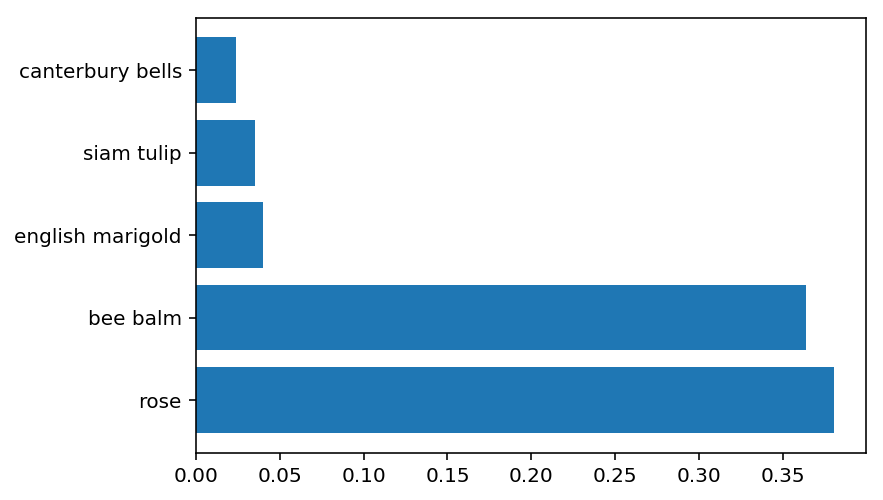

In [25]:
#@title
image_tensor = torch.from_numpy(process_image(test_image))
probs, classes = predict(test_image, checkpoint_best)
imshow(image_tensor)
plot_class_probs(probs, classes, cat_to_name)